<a href="https://www.kaggle.com/code/miltiadesgeneral/analyzing-the-data-and-building-multiple-ml-models?scriptVersionId=120125701" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
import random

%matplotlib inline

## Configuration

In [2]:
class Config:
    train_pathway = "/kaggle/input/titanic/train.csv"
    test_pathway = "/kaggle/input/titanic/test.csv"
    
    random_state = 42

In [3]:
train_df = pd.read_csv(Config.train_pathway)
new_cols = [col.lower() for col in train_df.columns]
train_df.columns = new_cols
train_df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Assessing the Data

Text(0.5, 1.0, 'NaN Counts for train_df columns')

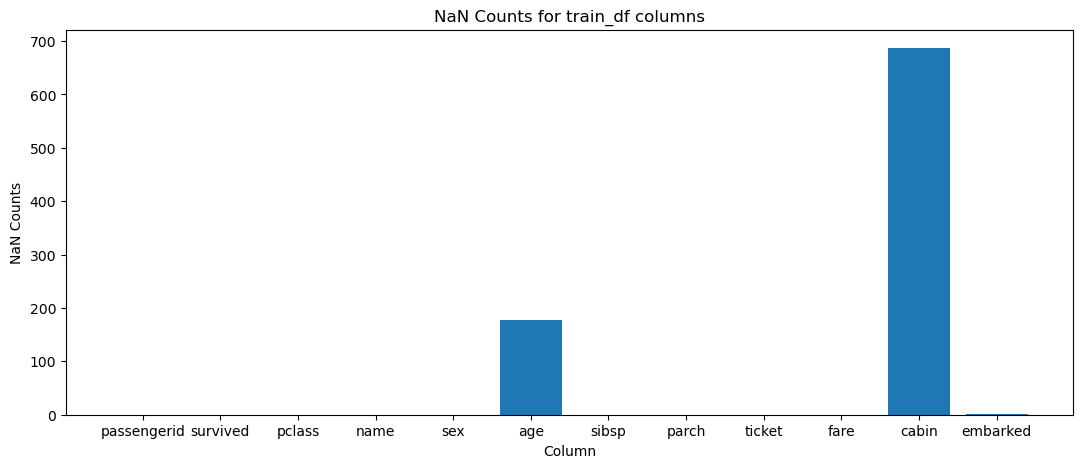

In [4]:
## Looking for holes in the data
df_nans = {}

for col in train_df.columns:
    df_nans[col] = train_df[col].isna().sum()

fig = plt.figure(figsize = (13, 5))
plt.bar(df_nans.keys(), df_nans.values())
plt.xlabel("Column")
plt.ylabel("NaN Counts")
plt.title("NaN Counts for train_df columns")

This shows that we may have to work around or take special precautions for the Age and Cabin categories. 

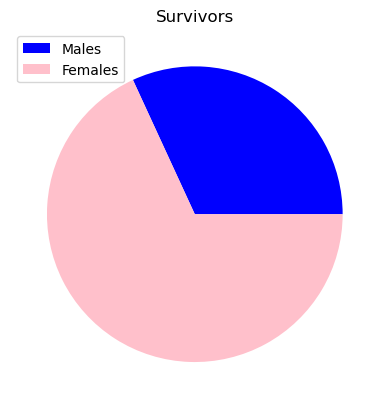

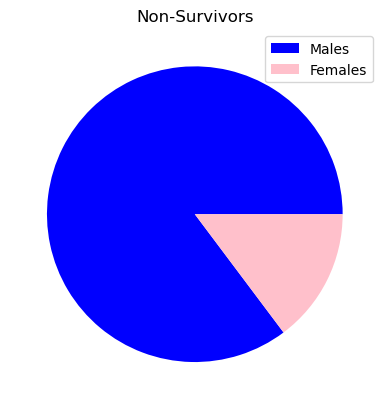

In [5]:
## Breakdown of survivors by gender
## Survived = 1, did not survive = 0

survivors_df = train_df[train_df["survived"] == 1]
non_survivors_df = train_df[train_df["survived"] == 0]

# Survivors by sex
male_survivors = survivors_df[survivors_df["sex"] == "male"]["passengerid"].count()
female_survivors = survivors_df[survivors_df["sex"] == "female"]["passengerid"].count()
survivors = [male_survivors, female_survivors]

# Non-survivors by sex
male_non_survivors = non_survivors_df[non_survivors_df["sex"] == "male"]["passengerid"].count()
female_non_survivors = non_survivors_df[non_survivors_df["sex"] == "female"]["passengerid"].count()
non_survivors = [male_non_survivors, female_non_survivors]

# Plot the two categories by sex
plt.figure(0)
plt.pie(survivors, colors=["blue", "pink"])
plt.title("Survivors")
plt.legend(["Males", "Females"])

plt.figure(1)
plt.pie(non_survivors, colors=["blue", "pink"])
plt.title("Non-Survivors")
plt.legend(["Males", "Females"])

In [6]:
# Dummy encode the sex and embarked columns
train_df["sex"] = train_df["sex"].map({"male": 0, "female": 1})
train_df["embarked"] = train_df["embarked"].map({ "C": 0, "Q": 1, "S": 2})

Text(0.5, 1.0, 'Passengers Onboard by Economic Class')

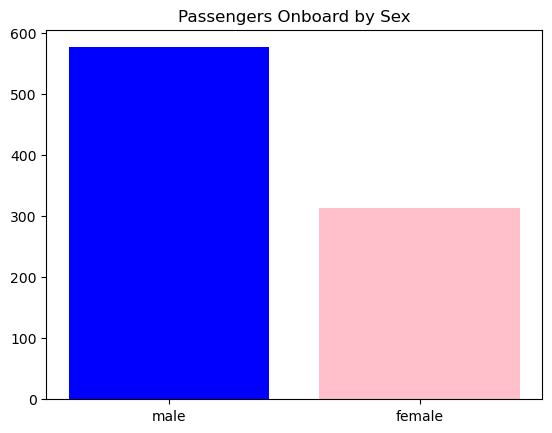

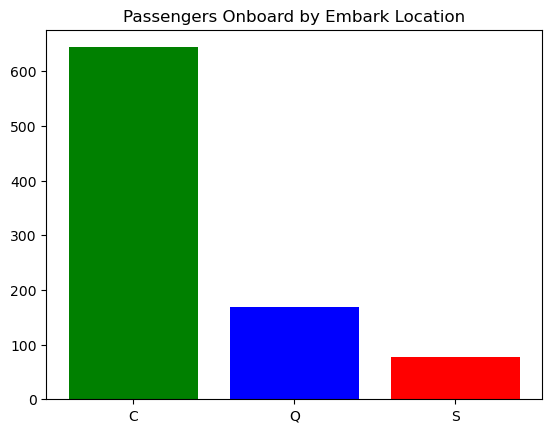

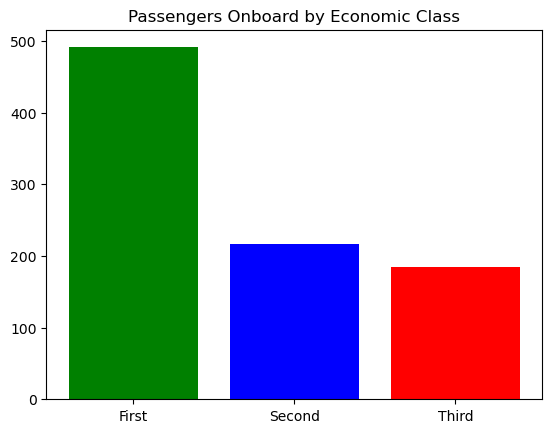

In [7]:
# Plot value counts for relevant categories
plt.figure(0)
plt.bar(["male", "female"], train_df["sex"].value_counts(), color=["blue", "pink"])
plt.title("Passengers Onboard by Sex")
plt.figure(1)
plt.bar(["C", "Q", "S"], train_df["embarked"].value_counts(), color=["green", "blue", "red"])
plt.title("Passengers Onboard by Embark Location")
plt.figure(2)
plt.bar(["First", "Second", "Third"], train_df["pclass"].value_counts(), color=["green", "blue", "red"])
plt.title("Passengers Onboard by Economic Class")

### Create a correlation matrix among the variables

In [8]:
# Separate the strictly numerical columns minus the passengerid
train_df_numerical_cols = ["survived", "pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
numerical_train_df = train_df[train_df_numerical_cols]

In [9]:
class PandasHelper():
    def fillAgeGaps(self, df):
        """
        Fill the data points that don't have a recorded age with the average age according to the number of children that they have
        
            Parameters:
                df (pandas dataframe): Contains a column for "age" and "parch"
            
            Returns:
                None. Modifies the dataframe in place.
        """
        _parch_dct = {ch: 0 for ch in range(int(min(df["parch"])), int(max(df["parch"]) + 1))}
        for ch in _parch_dct:
            _parch_dct[ch] = df[df["parch"]==ch]["age"].mean()

        for i in df.index:
            if pd.isna(df["age"].iloc[i]):
                _ch = df.iloc[i]["parch"]
                df.loc[i, "age"] = _parch_dct[_ch] if not np.isnan(_parch_dct[_ch]) else _parch_dct[6]
    
    def fillEmbarkGaps(self, df):
        """
        Fill the data points that don't have a recorded embarked location with the mode of the dataset.
        
            Parameters:
                df (pandas dataframe): Contains a column labeled "embarked"
            Returns:
                df (pandas dataframe)
        """
        _fill_loc = df["embarked"].mode().iloc[0]
        df["embarked"].fillna(_fill_loc, inplace=True)
        return df

    def fillCabinGaps(self, df):
        """
        Fill the data points that don't have a recorded cabin with a random cabin from within that economic class.
        
            Parameters:
                df (pandas dataframe): Contains a "cabin" column and a "pclass" column
                
            Returns:
                df (pandas dataframe): A concatenated dataframe containing data from each economic class in ascending order.
        """
        _first_class_df = df[df["pclass"] == 1]
        _second_class_df = df[df["pclass"] == 2]
        _third_class_df = df[df["pclass"] == 3]
        
        _first_class_cabins = list(_first_class_df["cabin"].dropna())
        _second_class_cabins = list(_second_class_df["cabin"].dropna())
        _third_class_cabins = list(_third_class_df["cabin"].dropna())
        
        def _cabin_helper(_cabins):
            """
            Creates a lambda function for the class separated dataframe.
            
                Parameters:
                    _cabins (list): List of cabins belonging to a specified class
                    _maxRange (int): Len of specified cabins list
                
                Return:
                
            """
            return lambda row: row.at["cabin"] if not pd.isna(row["cabin"]) else np.random.choice(_cabins)
        
        _first_lambda = _cabin_helper(_first_class_cabins)
        _second_lambda = _cabin_helper(_second_class_cabins)
        _third_lambda = _cabin_helper(_third_class_cabins)
        
        _first_class_df = _first_class_df.apply(_first_lambda, axis=1)
        _second_class_df = _second_class_df.apply(_second_lambda, axis=1)
        _third_class_df = _third_class_df.apply(_third_lambda, axis=1)
        
        return pd.concat([_first_class_df, _second_class_df, _third_class_df])
    
    def fillFareGaps(self, df):
        """
        Fill the data points that don't have a recorded age with the average age according to the number of children that they have
        
            Parameters:
                df (pandas dataframe): Contains a column for "fare" and "pclass"
            
            Returns:
                None. Modifies the dataframe in place.
        """
        _pclass_dct = {ch: 0 for ch in range(1, int(max(df["pclass"]) + 1))}
        for _class in _pclass_dct:
            _pclass_dct[_class] = df[df["pclass"]==_class]["fare"].mean()

        for i in df.index:
            if pd.isna(df["fare"].iloc[i]):
                _class = df.iloc[i]["pclass"]
                df.loc[i, "fare"] = _pclass_dct[_class]
        
    def separateClasses(self, df):
        _first_class_df = df[df["pclass"]==1]
        _second_class_df = df[df["pclass"]==2]
        _third_class_df = df[df["pclass"]==3]
        
        return pd.concat([_first_class_df, _second_class_df, _third_class_df])

    
    def encodeCabins(self, df):
        """
        Gives a numerical encoding for each cabin in a dataframe.
        
            Parameters:
                df (pandas dataframe): Contains a "cabin" column.
            Return:
                None. Modifies the dataframe in place.
        """
        _cab_dct = {}
        _num_cabins = len(df["cabin"].unique())
        
        for i, _cabin in enumerate(df["cabin"].unique()):
            _cab_dct[_cabin] = i
            
        for i, row in df.iterrows():
            _cab_key = row["cabin"]
            df.loc[i, "cabin"] = _cab_dct[_cab_key]
    
    def encodeAges(self, df):
        """
        Creates categorical variables for the ages in increments of 16 years.
        
            Parameters:
                df (pandas dataframe): Contains a column for ages
            
            Returns:
                None, modifies the dataframe in place
        
        """
        df.loc[(df["age"] <= 16), "age"] = 1
        df.loc[(df["age"] > 16) & (df["age"] <= 32), "age"] = 2
        df.loc[(df["age"] > 32) & (df["age"] <= 48), "age"] = 3
        df.loc[(df["age"] > 48) & (df["age"] <= 64), "age"] = 4
        df.loc[(df["age"] > 64), "age"] = 5
    
    def logFare(self, df):
        """
        Replaces the fare with the log of the fare.
        
            Parameters:
                df (pandas dataframe): Contains a column for ages
                
            Returns:
                None, modifies the dataframe in place
        """
        df.loc[:, "fare"] = np.log(df["fare"].astype("float64"))
        df.loc[df["fare"] == float("-inf"), "fare"] = 0
    

In [10]:
# Apply the helper functions to the dataframe to fill missing values
helper = PandasHelper()
helper.fillAgeGaps(numerical_train_df)
helper.fillEmbarkGaps(numerical_train_df)

display(f'Age NaNs: {numerical_train_df["age"].isna().sum()}')
display(f'Embark NaNs: {numerical_train_df["embarked"].isna().sum()}')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


'Age NaNs: 0'

'Embark NaNs: 0'

<AxesSubplot:>

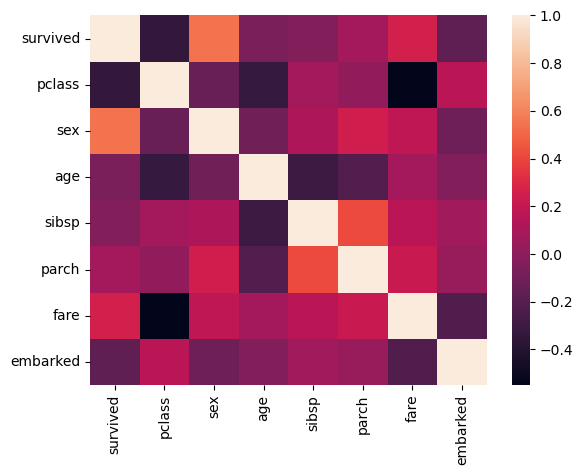

In [11]:
# Create a correlation matrix for the columns in the dataframe. Create a heatmap from the correlation matrix
corr_matrix = numerical_train_df.corr()
sns.heatmap(corr_matrix)

In [12]:
numerical_train_df[numerical_train_df["survived"]==0]["pclass"]

0      3
4      3
5      3
6      1
7      3
      ..
884    3
885    3
886    2
888    3
890    3
Name: pclass, Length: 549, dtype: int64

Text(0.5, 1.0, 'Non-Survivors by Economic Class')

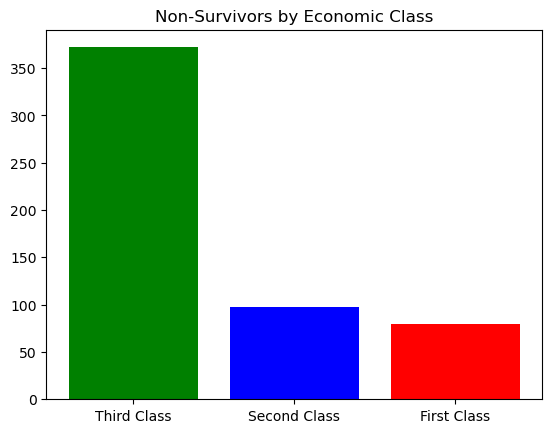

In [13]:
plt.bar(["Third Class", "Second Class", "First Class"], numerical_train_df[numerical_train_df["survived"]==0]["pclass"].value_counts(), color=["green", "blue", "red"])
plt.title("Non-Survivors by Economic Class")

Survived appears to have a strong correlation with the sex of the passenger. Other factors that had strong correlation were fair and pclass, which had a very strong negative correlation (higher pclass corresponds to lower income class). Fare and pclass have a high correlation so only one need to be included in the model.

## Building Some Machine Learning Models

#### Classification Models:


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [15]:
train_df = numerical_train_df.copy()

### Preprocessing the Data

In [16]:
# Preprocessing
# Only include one of "pclass", "fare"
independent_variables = ["sex", "pclass", "age", "sibsp", "parch", "embarked"]
X, y = train_df[independent_variables], train_df["survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=Config.random_state)

display(f"X_train length: {len(X_train)}")
display(f"X_test length: {len(X_test)}")

'X_train length: 757'

'X_test length: 134'

In [17]:
# Standard Scale the training Data and transform the dataframe
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

### Logistic Regression Model

In [18]:
lgr = LogisticRegression().fit(X_train, y_train)
preds = lgr.predict(X_test)

In [19]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.88      0.85        78
           1       0.82      0.71      0.76        56

    accuracy                           0.81       134
   macro avg       0.81      0.80      0.80       134
weighted avg       0.81      0.81      0.81       134



#### The Logistic Regression Model performed well with a f1 score of 0.81

### DecisionTree Classifier

In [20]:
dtr = DecisionTreeClassifier().fit(X_train, y_train)
preds =  dtr.predict(X_test)

In [21]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.82      0.80        78
           1       0.73      0.66      0.69        56

    accuracy                           0.75       134
   macro avg       0.75      0.74      0.74       134
weighted avg       0.75      0.75      0.75       134



#### The Decision Tree Classifier faired worse than the Logistic Regression with an accuracy of 0.78

### Random Forest Classifier

In [22]:
rfr = RandomForestClassifier().fit(X_train, y_train)
preds = rfr.predict(X_test)

In [23]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79        78
           1       0.71      0.73      0.72        56

    accuracy                           0.76       134
   macro avg       0.75      0.76      0.76       134
weighted avg       0.76      0.76      0.76       134



#### Random Forest Has the lowest Performance with 0.77 f1 score

## Feature Engineering

In [24]:
full_df = pd.read_csv(Config.train_pathway)
new_cols = [col.lower() for col in full_df.columns]
full_df.columns = new_cols
full_df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
helper = PandasHelper()

cabins_df = helper.fillCabinGaps(full_df)
full_df = helper.separateClasses(full_df)
full_df["cabin"] = cabins_df
full_df

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
...,...,...,...,...,...,...,...,...,...,...,...,...
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,F E69,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,F38,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,G6,Q
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,G6,S


In [26]:
full_df.reset_index(inplace=True)
full_df.drop("index", axis=1, inplace=True)

In [27]:
helper.encodeCabins(full_df)
helper.fillEmbarkGaps(full_df)
helper.fillAgeGaps(full_df)

display(f'Age NaNs: {full_df["age"].isna().sum()}')
display(f'Embark NaNs: {full_df["embarked"].isna().sum()}')

'Age NaNs: 0'

'Embark NaNs: 0'

In [28]:
# Dummy encode.add_suffixthe sex and embarked columns
full_df["sex"] = full_df["sex"].map({"male": 0, "female": 1})
full_df["embarked"] = full_df["embarked"].map({ "C": 0, "Q": 1, "S": 2})
helper.encodeAges(full_df)
helper.logFare(full_df)
full_df

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3.0,1,0,PC 17599,4.266662,0,0
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3.0,1,0,113803,3.972177,1,2
2,7,0,1,"McCarthy, Mr. Timothy J",0,4.0,0,0,17463,3.948596,2,2
3,12,1,1,"Bonnell, Miss. Elizabeth",1,4.0,0,0,113783,3.279030,3,2
4,24,1,1,"Sloper, Mr. William Thompson",0,2.0,0,0,113788,3.569533,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
886,883,0,3,"Dahlberg, Miss. Gerda Ulrika",1,2.0,0,0,7552,2.352964,144,2
887,885,0,3,"Sutehall, Mr. Henry Jr",0,2.0,0,0,SOTON/OQ 392076,1.953028,145,2
888,886,0,3,"Rice, Mrs. William (Margaret Norton)",1,3.0,0,5,382652,3.371597,143,1
889,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,2.0,1,2,W./C. 6607,3.154870,143,2


In [29]:
# Create a new column called social ranking
# socrnk = (age + fare) / pclass
# We will use this category to replace age, fair and pclass

full_df["socrnk"] = (full_df["age"] + full_df["fare"]) / full_df["pclass"]
full_df

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,socrnk
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3.0,1,0,PC 17599,4.266662,0,0,7.266662
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3.0,1,0,113803,3.972177,1,2,6.972177
2,7,0,1,"McCarthy, Mr. Timothy J",0,4.0,0,0,17463,3.948596,2,2,7.948596
3,12,1,1,"Bonnell, Miss. Elizabeth",1,4.0,0,0,113783,3.279030,3,2,7.279030
4,24,1,1,"Sloper, Mr. William Thompson",0,2.0,0,0,113788,3.569533,4,2,5.569533
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,883,0,3,"Dahlberg, Miss. Gerda Ulrika",1,2.0,0,0,7552,2.352964,144,2,1.450988
887,885,0,3,"Sutehall, Mr. Henry Jr",0,2.0,0,0,SOTON/OQ 392076,1.953028,145,2,1.317676
888,886,0,3,"Rice, Mrs. William (Margaret Norton)",1,3.0,0,5,382652,3.371597,143,1,2.123866
889,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,2.0,1,2,W./C. 6607,3.154870,143,2,1.718290


In [30]:
full_df.isna().sum()

passengerid    0
survived       0
pclass         0
name           0
sex            0
age            0
sibsp          0
parch          0
ticket         0
fare           0
cabin          0
embarked       0
socrnk         0
dtype: int64

In [31]:
full_df

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,socrnk
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3.0,1,0,PC 17599,4.266662,0,0,7.266662
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3.0,1,0,113803,3.972177,1,2,6.972177
2,7,0,1,"McCarthy, Mr. Timothy J",0,4.0,0,0,17463,3.948596,2,2,7.948596
3,12,1,1,"Bonnell, Miss. Elizabeth",1,4.0,0,0,113783,3.279030,3,2,7.279030
4,24,1,1,"Sloper, Mr. William Thompson",0,2.0,0,0,113788,3.569533,4,2,5.569533
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,883,0,3,"Dahlberg, Miss. Gerda Ulrika",1,2.0,0,0,7552,2.352964,144,2,1.450988
887,885,0,3,"Sutehall, Mr. Henry Jr",0,2.0,0,0,SOTON/OQ 392076,1.953028,145,2,1.317676
888,886,0,3,"Rice, Mrs. William (Margaret Norton)",1,3.0,0,5,382652,3.371597,143,1,2.123866
889,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,2.0,1,2,W./C. 6607,3.154870,143,2,1.718290


### Data Preprocessing

In [32]:
# Preprocessing
# Only include one of "pclass", "fare"
independent_variables = ["sex", "sibsp", "parch", "cabin", "embarked", "socrnk"]
X, y = full_df[independent_variables], full_df["survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=Config.random_state)

display(f"X_train length: {len(X_train)}")
display(f"X_test length: {len(X_test)}")

'X_train length: 757'

'X_test length: 134'

In [33]:
# Standard Scale the test data

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

### Logistic Regression Model

In [34]:
lgr = LogisticRegression(random_state=Config.random_state).fit(X_train, y_train)
preds = lgr.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [35]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        79
           1       0.84      0.76      0.80        55

    accuracy                           0.84       134
   macro avg       0.84      0.83      0.84       134
weighted avg       0.84      0.84      0.84       134



### Random Forest Classifier

In [36]:
# rfr = RandomForestClassifier().fit(X_train, y_train)
rfr = RandomForestClassifier(n_estimators=200, max_samples=0.6, random_state=Config.random_state).fit(X_train, y_train)
preds = rfr.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [37]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.16      0.27        79
           1       0.43      0.91      0.58        55

    accuracy                           0.47       134
   macro avg       0.58      0.54      0.43       134
weighted avg       0.60      0.47      0.40       134



## Logistic Regression had the Highest Performance so it will be used for Submission

### Submission

In [38]:
test_df = pd.read_csv(Config.test_pathway)
new_cols = [col.lower() for col in test_df.columns]
test_df.columns = new_cols
helper = PandasHelper()

cabins_df = helper.fillCabinGaps(test_df)
test_df = helper.separateClasses(test_df)
test_df["cabin"] = cabins_df

test_df.reset_index(inplace=True)
test_df.drop("index", axis=1, inplace=True)

helper.encodeCabins(test_df)
helper.fillEmbarkGaps(test_df)
helper.fillAgeGaps(test_df)
helper.fillFareGaps(test_df)

display(f'Age NaNs: {test_df["age"].isna().sum()}')
display(f'Embark NaNs: {test_df["embarked"].isna().sum()}')

# Dummy encode.add_suffixthe sex and embarked columns
test_df["sex"] = test_df["sex"].map({"male": 0, "female": 1})
test_df["embarked"] = test_df["embarked"].map({ "C": 0, "Q": 1, "S": 2})
helper.encodeAges(test_df)
helper.logFare(test_df)

# Create a new column called social ranking
# socrnk = (age + fare) / pclass
# We will use this category to replace age, fair and pclass

test_df["socrnk"] = (test_df["age"] + test_df["fare"]) / test_df["pclass"]
test_df



'Age NaNs: 0'

'Embark NaNs: 0'

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,socrnk
0,903,1,"Jones, Mr. Charles Cresson",0,3.0,0,0,694,3.258097,0,2,6.258097
1,904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",1,2.0,1,0,21228,4.409966,1,2,6.409966
2,906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",1,3.0,1,0,W.E.P. 5734,4.113739,2,2,7.113739
3,912,1,"Rothschild, Mr. Martin",0,4.0,1,0,PC 17603,4.084294,2,0,8.084294
4,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",1,2.0,0,0,PC 17598,3.455790,3,2,5.455790
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1304,3,"Henriksson, Miss. Jenny Lovisa",1,2.0,0,0,347086,2.050913,75,2,1.350304
414,1305,3,"Spector, Mr. Woolf",0,2.0,0,0,A.5. 3236,2.085672,74,2,1.361891
415,1307,3,"Saether, Mr. Simon Sivertsen",0,3.0,0,0,SOTON/O.Q. 3101262,1.981001,72,2,1.660334
416,1308,3,"Ware, Mr. Frederick",0,2.0,0,0,359309,2.085672,74,2,1.361891


In [39]:
# Preprocessing
# Only include one of "pclass", "fare"
independent_variables = ["sex", "sibsp", "parch", "cabin", "embarked", "socrnk"]
X = test_df[independent_variables]


# Standard Scale the testing data

scaler = StandardScaler().fit(X)
X_test = scaler.transform(X)
display(f"X_test length: {len(X_test)}")

'X_test length: 418'

In [40]:
preds = lgr.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [41]:
submission_df = pd.DataFrame()
submission_df["PassengerId"] = test_df["passengerid"]
submission_df["Survived"] = preds

In [42]:
submission_df.to_csv("submission.csv", index=False)